 Modeling Phase of project. 

# Introduction

Weather forecasting has been a significant area for application of advanced deep learning and machine learning methodologies over traditional methods to improve weather prediction. These new methods are appropriate for processing large chunks of data where massive quantity of historic weather datasets could be utilized for forecasting. This sample showcases two autoregressive methods: one using a deep learning and another using a machine learning framework to predict temperature and Air Quality Index of an ECO-Village.

Idea calculate from this: https://www.breeze-technologies.de/blog/what-is-an-air-quality-index-how-is-it-calculated/

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML
# Basic for the manual the data set. 
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# Apply for traning the model. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
# Another library
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Workwith datasets which belong from the data sensor where the input should be from the two month as the beginning stage. 
Client provide the Data from Sensor which call GituHoo. The sensor data store into computer and share to us by client. 
This is only a few month might affect to the accuracy level of the modeling. 

In [2]:
Febuary = pd.read_csv('/home/markn/Desktop/DataSensor/FebData.csv')
March = pd.read_csv('/home/markn/Desktop/DataSensor/MarchData.csv')
# January = pd.read_csv('/home/markn/Desktop/DataSensor/January.csv')

# Apply the current dataset. Client send us dataset sometimes follow what the client have. We are not alway have real-time 

bigdatasensor = pd.concat([Febuary, March], ignore_index=True, sort=False)
# bigdatasensor.head()
bigdatasensor = bigdatasensor.rename(columns = {'Date and Time': 'dt', 'PM2.5': 'PM25'}, inplace = False)
# Rename some collumn to make it clean and easy to load. 
bigdatasensor['dt'] = pd.to_datetime(bigdatasensor['dt'])
bigdatasensor.columns = [c.replace(' ', '_') for c in bigdatasensor.columns]
# Add the underscore between 2 word. With the aim to call the feature in easy. 


d = bigdatasensor.copy()
# copy() mean make the new version of dataset. 

In [3]:
d.sort_values('dt', inplace=True)

# Sort the value follow Datetime ('dt') collumns. 

# Air Quality Index Calculate 
## Air quality index Convert in this note-book

<center><img src='https://i.imgur.com/GL2BaU4.png'></center>

* The AQI calculation uses 7 measures: PM2.5, NOx, NH3, TVOC and CO2.

* For PM2.5, PM10, SO2, NOx and NH3 the average value in last 24-hrs is used with the condition of having at least 16 values. ( in here we do have per minutes of each hour) 

* For CO and O the maximum value in last 8-hrs is used. Mainly because the sensor locate inside, it default in 0 index. 

* Each measure is converted into a Sub-Index based on pre-defined groups.

* Sometimes measures are not available due to lack of measuring or lack of required data points.

* Sub-index from based index being standardized. 

* Final AQI is the maximum Sub-Index with the condition that at least one of PM2.

Check REF: https://www.kaggle.com/rohanrao/calculating-aqi-air-quality-index-tutorial


In [4]:
## PM2.5 Sub-Index calculation

## PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). 
## The predefined groups are defined in the function below:
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

d["PM2.5_SubIndex"] = d["PM25"].apply(lambda x: get_PM25_subindex(x))

## NOx Sub-Index calculation: 
## NOx is measured in ppb (parts per billion). The predefined groups are defined in the function below:
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["NOx_SubIndex"] = d["NO2"].apply(lambda x: get_NOx_subindex(x))

## CO Sub-Index calculation
## CO is measured in mg / m3 (milligrams per cubic meter of air). 
## The predefined groups are defined in the function below:

def get_CO2_subindex(x):
    if x <= 700:
        return x * 50 / 700
    elif x <= 800:
        return 50 + (x - 700) * 50 / 100
    elif x <= 1100:
        return 100 + (x - 800) * 100 / 300
    elif x <= 1500:
        return 200 + (x - 1100) * 100 / 400
    elif x <= 2000:
        return 300 + (x - 1500) * 100 / 500
    elif x > 2000:
        return 400 + (x - 2000) * 100 / 500
    else:
        return 0

d["CO2_SubIndex"] = d["CO2"].apply(lambda x: get_CO2_subindex(x))

## TVOC Sub-Index calculation:

def get_TVOCx_subindex(x):
    if x <= 250:
        return x * 50 / 250
    elif x <= 500:
        return 50 + (x - 250) * 50 / 250
    elif x <= 1000:
        return 100 + (x - 500) * 100 / 500
    elif x <= 2500:
        return 200 + (x - 1000) * 100 / 1500
    elif x <= 3000:
        return 300 + (x - 2500) * 100 / 500
    elif x > 3000:
        return 400 + (x - 3000) * 100 / 500
    else:
        return 0

d["TVOCx_SubIndex"] = d["TVOC"].apply(lambda x: get_TVOCx_subindex(x))

## TVOC Sub-Index calculation:

def get_Ozonex_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["Ozonex_SubIndex"] = d["Ozone"].apply(lambda x: get_Ozonex_subindex(x))

# Make the right sub index to return right value to calculate the Air Quality Index. 

## AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

The pre-defined buckets of AQI are as follows: 

<center><img src='https://i.imgur.com/XmnE0rT.png'></center>


In [5]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe | Danger"
    else:
        return np.NaN
# This function support the change of threshold of Air Index followed the picture above.  
   
d["Checks"] = (d["PM2.5_SubIndex"] > 0).astype(int) + \
                        (d["TVOCx_SubIndex"] > 0).astype(int) + \
                        (d["NOx_SubIndex"] > 0).astype(int) + \
                        (d["Ozonex_SubIndex"] > 0).astype(int) + \
                        (d["CO2_SubIndex"] > 0).astype(int)
# The average level of AQI from 1 to 5 index. Arrange from healthy to danger from level 1 to level 5. 

d["AQI_calculated"] = round(d[["PM2.5_SubIndex", "NOx_SubIndex",
                                  "CO2_SubIndex", "Ozonex_SubIndex", "TVOCx_SubIndex"]].max(axis = 1))
# Finally calculate the AQI from the sub_index. 

# # d.loc[d["PM2.5_SubIndex"] + d["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
# d.loc[d.Checks < 3, "AQI_calculated"] = np.NaN

d["AQI_bucket_calculated"] = d["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
# Convert them into messsage which show in word. By apply the lambda into function above. 

d[~d.AQI_calculated.isna()].head(13)
# Check NA. 
       
d.head(10)

,dt,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,Virus_Index,PM2.5_SubIndex,NOx_SubIndex,CO2_SubIndex,TVOCx_SubIndex,Ozonex_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2021-02-01 09:24:00,7.2,76.5,1,0,712,0,990.6,8.0,19.4,9,1.666667,24.25,56.000000,0.0,10.0,4,56.0,Satisfactory
1,2021-02-01 09:25:00,8.3,72.3,1,0,704,0,990.5,8.0,19.4,9,1.666667,24.25,52.000000,0.0,10.0,4,52.0,Satisfactory
2,2021-02-01 09:26:00,9.1,69.3,1,0,668,0,990.6,8.0,19.4,8,1.666667,24.25,47.714286,0.0,10.0,4,48.0,Good
3,2021-02-01 09:27:00,9.6,67.0,2,0,639,0,990.5,8.0,19.4,8,3.333333,24.25,45.642857,0.0,10.0,4,46.0,Good
4,2021-02-01 09:28:00,9.9,65.2,1,0,618,0,990.6,8.0,19.4,8,1.666667,24.25,44.142857,0.0,10.0,4,44.0,Good
5,2021-02-01 09:29:00,10.2,64.0,1,0,580,0,990.6,8.0,19.4,6,1.666667,24.25,41.428571,0.0,10.0,4,41.0,Good
6,2021-02-01 09:30:00,10.5,63.1,5,0,542,0,990.6,8.0,19.4,6,8.333333,24.25,38.714286,0.0,10.0,4,39.0,Good
7,2021-02-01 09:31:00,10.6,62.4,3,0,525,0,990.6,8.0,19.4,6,5.000000,24.25,37.500000,0.0,10.0,4,38.0,Good
8,2021-02-01 09:32:00,10.8,61.8,9,0,516,0,990.6,8.0,19.4,6,15.000000,24.25,36.857143,0.0,10.0,4,37.0,Good
9,2021-02-01 09:33:00,10.9,61.3,4,0,508,0,990.5,8.0,19.4,6,6.666667,24.25,36.285714,0.0,10.0,4,36.0,Good


/home/markn/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


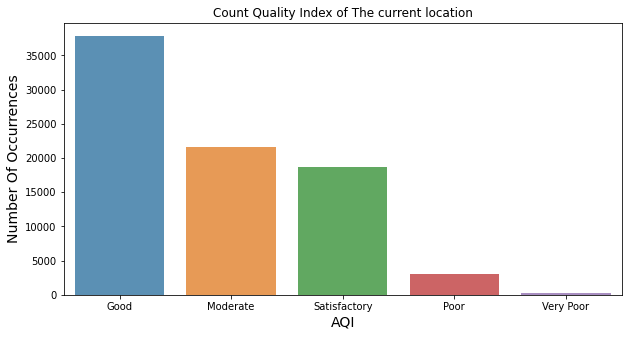

In [6]:
value_index = d['AQI_bucket_calculated'].value_counts() 
# Calculate how many unit of AQI index by value_count() function. 
value_index = value_index[:10,]
# Get the first 10 value_index. 
plt.figure(figsize=(10,5)) 
# Set the plot figsize of the plot. 
sns.barplot(value_index.index, value_index.values, alpha=0.8)
# Use barplot from Seaborn library which import from the above. 
plt.title('Count Quality Index of The current location')
plt.ylabel('Number Of Occurrences', fontsize=14)
plt.xlabel('AQI',fontsize=14)
plt.show()
# This plot show the data of AQI how result are performing. 

# Convert to Timeseries format

This dataset is now transformed into a timeseries data format where the Date column is set as the index of the dataset.


In [7]:
AQI = d.copy()
AQI = AQI.rename(columns = {'dt':'Date'})
# Rename of the feature. 
AQI["hour"] = [x.hour for x in AQI["Date"]]
# Extract the hour 
AQI["minutes"] = [x.minute for x in AQI["Date"]]
# Extract the minutes
AQI["day"] = [x.day for x in AQI["Date"]]
# Get day in collums 
AQI['Date'] = AQI['Date'].dt.strftime('%Y-%m-%d')
# Extract the date from Date follow Year month day. 

This would be a function to make the notebook being more easy to read. 

In [8]:
AQI = AQI.groupby(['Date', 'hour']).mean().reset_index()
# AQI = AQI.groupby(['Date']).mean().reset_index()
# Group day and the same hour, and get average of all of them < we want to calculate the average with small dataset in hour > 
AQI = AQI.drop(['PM2.5_SubIndex', 'NOx_SubIndex', 'CO2_SubIndex', 'TVOCx_SubIndex', 'Ozonex_SubIndex', 'Checks', 'Virus_Index','day','hour','minutes'], axis=1)
AQI[AQI.columns[0]] = pd.to_datetime(AQI[AQI.columns[0]], format='%Y-%m-%d')
# Get separate year-month-day
AQI = AQI.set_index(AQI.columns[0])
# Set the index of AQI. 
AQI = AQI.sort_index()
# Sort the dataset in right number. 
all_air_index = AQI.astype('float')
# Change all data data type to float. 
all_air_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1364 entries, 2021-02-01 to 2021-03-31
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1364 non-null   float64
 1   Relative_Humidity  1364 non-null   float64
 2   PM25               1364 non-null   float64
 3   TVOC               1364 non-null   float64
 4   CO2                1364 non-null   float64
 5   CO                 1364 non-null   float64
 6   Air_Pressure       1364 non-null   float64
 7   Ozone              1364 non-null   float64
 8   NO2                1364 non-null   float64
 9   AQI_calculated     1364 non-null   float64
dtypes: float64(10)
memory usage: 117.2 KB


In [9]:
all_air_index

,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,AQI_calculated
Date,,,,,,,,,,
2021-02-01,10.928125,61.328125,3.406250,0.000000,527.812500,0.0,990.562500,7.493750,17.571875,37.781250
2021-02-01,17.775000,45.005000,20.975000,10.350000,1034.950000,0.0,990.857500,6.627500,14.567500,178.100000
2021-02-01,18.250000,43.955000,13.066667,103.516667,822.450000,0.0,991.105000,2.500000,0.533333,106.350000
2021-02-01,19.841667,40.856667,11.016667,112.133333,755.400000,0.0,991.863333,2.500000,0.505000,77.716667
2021-02-01,21.178333,37.435000,9.283333,72.283333,698.200000,0.0,992.496667,2.525000,0.478333,60.250000
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,25.913333,30.093333,5.283333,247.900000,542.750000,0.0,1017.741667,3.778333,0.491667,57.633333
2021-03-31,25.923333,30.143333,5.700000,311.783333,538.500000,0.0,1017.948333,3.386667,0.465000,62.416667
2021-03-31,25.273333,30.345000,4.866667,682.350000,550.800000,0.0,1018.138333,3.326667,0.431667,128.433333


# Data Normalization before Modeling 

In [10]:
# This one is a testing split train and test data to obeserve the nomalization. 
column_indices = {name: i for i, name in enumerate(all_air_index.columns)}
# The column indice and name it by i use for every index
n = len(all_air_index)
train_df = all_air_index[0:int(n*0.7)]
val_df = all_air_index[int(n*0.7):int(n*0.9)]
test_df = all_air_index[int(n*0.9):]
# The testing split of train and validation and test set 
num_features = all_air_index.shape[1]

# Calculate the mean and standardized. 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

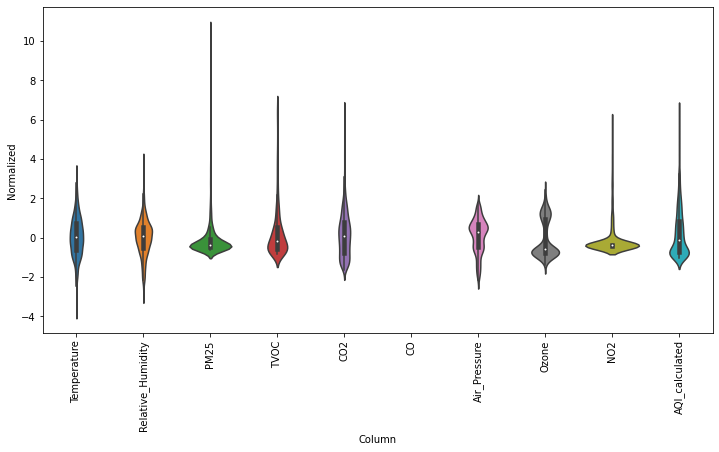

In [11]:
df_std = (all_air_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(all_air_index.keys(), rotation=90)
# Apply the plot show to the nomalization of data for each feature. 

There all different of features which stay quite normalizaed after applied normalization teachnie. The tail range of PM25 is long to the top combine with TVOC and CO2. 
Especially is CO is stay on 0 number and it will stay low because the sensor is in the house, it might raise and sensor the CO high if any fire happended. We don't need to notice this one mainly. 

Reference of Normalization Data: https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network

# Model Building

Once the dataset is transformed into a timeseries dataset, it is ready to be used for modelling. In this sample two types of methodology are used for modelling:

1) LSTM - First a deep learning framework of LSTM is used which is appropriate for handling time series data.

2) Support Vector Machine - In the second option the machine learning algorithm of Support Vector Regression(SVR) is used to compare the performance between the two methods in terms of accuracy and computation time.

# Support Vector Machine 

Support Vector Machine was first proposed by Vladimir Vapnik as a binary linear classifier in 1963 which was further developed in 1992 to a non linear classifier. This algorithm classifies data by creating hyperplanes between different classes using the maximal margin method. The maximum margin represented as epsilon(ε) is the maximum separation distance(2ε) that can be achieved between the nearest data points of the two classes. These data points which are critical for the hyperplane are known as support vectors.

This study being a regression problem, here its regression variant also known as Support Vector Regression (SVR) is used, which was proposed in 1996 by Vapnik .et.al, suitable for regression in high dimensionality space. The algorithm uses the same maximal margin principle but instead of separating classes it creates a tube with a radius of epsilon(ε) to include the data points. The primary parameters for SVR are the kernel function and its coefficient required to map the data points to a higher dimension space, epsilon(ε) or tube radius, and C or cost as penalty.

In the second method this machine learning algorithm of Support Vector Regression (SVR) is applied to compare performances by the deep learning framework, since it is suitable for fitting high dimensional data with comparatively fewer samples.

Accordingly a function is first created which would first receive the time series data, followed by fitting it using the ML model and forecasting daily for the month of April, 2021.

The support vector regression here uses a radial basis function or rbf as the kernel, a moderate cost value of C=10 and an epsilon of 0.001. These are the critical parameters for the svr model, which can be further tuned for better result. This is then fitted on the train set and predicted on the test set, with accuracy of the fit measured in terms of R-squared.

<center><img src='https://i2.wp.com/dataaspirant.com/wp-content/uploads/2017/01/Support-vector-machine-svm.jpg?resize=690%2C518' width="400" height="500"></center>



In [12]:
# create future forecast dates
def create_dates(start,days):
    v = pd.date_range(start=start, periods=days+1, freq='D', closed='right')
    #creat the periods day forward +1 days. 
    seven_day_forecast = pd.DataFrame(index=v) 
    # index of seven_day_forcase should store into v. ( here for example we forcast 21 days, 7 days to each of period, 
    # it is one of the reason to see in the plot which show for every 7 days period)
    return seven_day_forecast
# This function we try to make the day period. 

In [13]:
# get values, station name and drop null values
def get_value_name(all_air_index,i):
    station_value = all_air_index[[all_air_index.columns[i]]].dropna()
    # If there is any na it should drop. 
    index_name = all_air_index.columns[i]
    # Repeat the index name. 
    return station_value, index_name 

In [14]:
# train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    # print the number of total samples 
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    # print he number  split samples
    print('Testing samples: ',nrow-split_row)
    # showrint he number  split samples
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row  

Data scaling is essential before feeding it to a LSTM, which helps it train better compared to raw unscaled data. This method scales the train and test data using a minmax scaler from sci-kit learn. 


In [15]:
# data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    # This estimator scales and translates each feature individually.
    # Such that it is in the given range on the training set, e.g. between zero and one.
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    # Fit_tranform function 
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler  

Finally one more transformation of feature engineering is required, which is to create new features using lagged values of the time series data itself. Here the number of lag terms could be specified and the function would create lag number of new features using the lagged terms.


In [16]:
# feature builder - This section creates feature set with lag number of predictors. 
#--Creating features using lagged data. 
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
        # Shift the lag of the day as LSTM, it calculated back from the previous on how many LAG values. 
    return df_copy
    df_copy = df.copy()



Null values resulting from the above feature creation are dropped followed by converting the train and test values to arrays, which is the input data type for LSTM.


# Preprocessing -- Drop Null values and make arrays 

In [17]:
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    # Drop an NA value on X_train array if it has the NULL values.
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    # Drop an NA value on y_train array if the collumn has NULL values. 
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    # Drop an NA values on X_test array if the collumn has NULL values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    # Drop an NA value on Y_test array if the collumns has NULL values. 
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array



Model with three hidden layer is created each having a user input number of LSTM memory units, with a dropout rate of 20% for each layer, and a final output dense layer predicting a single value.


# Fitting & Validating using SVR

In [18]:
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array):
    model_svr = SVR(kernel='rbf', gamma='auto', tol=0.001, C=10.0, epsilon=0.001)
    # SVR function is from the above life where it import scikitlearn with SVM as SVR. 
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)
    # Check the fit model with X_train, Y_train array
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
    # Predict the train set. 
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array) 
    # Predict the test set
    print('Test R-squared is: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))
    # Why SVR mean Support Vector use R-square score. 
    return model_svr, y_pred_test_tract1   

The forecasted value on the test set using the fitted model is estimated and included with the actual observed temperatures set for visualization

# validation result  

In [19]:
def valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag):
    new_test_tract1 = station_value.iloc[split_row:]
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
    y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
    test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)
    return test_tract1_pred

Once the model is validated the fitted model is used to forecast temperature for user input days using past data. This is also estimated using one day walk forward method as mentioned in case of LSTM.


In [20]:
# multi-step future forecast by apply the support vector machine. 
def forecast_svr(X_test_tract1_array, days ,model_svr, lag, scaler):
    last_test_sample = X_test_tract1_array[-1]        
    X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
    y_pred_last_sample = model_svr.predict(X_last_test_sample)  
    # support and define the define New_array and predict array 
    new_array = X_last_test_sample
    # Last Step of the sample output in new_array. 
    new_predict = y_pred_last_sample
    # y_prediction last sample output in new_predict
    new_array = X_last_test_sample
    # saving the last test_sample into new_array. 
    new_predict = y_pred_last_sample
    # Imagine we have multi-ple depend on the prediction 7 days period.
    
    seven_days_svr=[]
    
    # Store the prediction data sample into the array. Where it is focusing into the preidction of 7 days of different index.
    for i in range(0,days):               
            new_array = np.insert(new_array, 0, new_predict)                
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,lag))                
            new_predict = model_svr.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform([new_predict])
            # Inverse_trainform as explaination: 
            """Undo the scaling of X according to feature_range.
            Parameters
            ----------
            X : array-like of shape (n_samples, n_features)
                Input data that will be transformed. It cannot be sparse.
            After that returns:
            -------
            Xt : ndarray of shape (n_samples, n_features)
                Transformed data.
            """
            seven_days_svr.append(temp_predict[0][0].round(2))
            # Apply function of SVM as the append to add the air index, temp_predict identify air_index after inverse to be round up this float number. 
            
    return seven_days_svr 

All the above methods are finally included in the main function which will take three input of the historical temperature data, number of lag data to be used and the number of days to be forecasted.


In [21]:
def predict_function(all_air_index, lag, days):     
    # What is lag days: Lag the the previous of the history in the time scale. It will have the demonstration in the picture.
    # Where the function SVR or LSTM use the past of the day to gain the future prediction. 
    seven_day_forecast_svr = create_dates('2021-03-30',days)
    # Creat_Dates function 
    for i in range(len(all_air_index.columns)):
        
        # preprocessing
        station_value, index_name = get_value_name(all_air_index,i)       
        train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)       
        # it is where the test set is split into the amount of 80%. 
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)  
        # Data_trainsformation.  With the goal to reproduce the data-frame into the new shape, which apply train and test_tract1. 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)        
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                           test_tract1)

        # SVR modeling
        model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                                X_test_tract1_array, y_test_tract1_array)                       
        test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag)        
        seven_days_svr = forecast_svr(X_test_tract1_array, days, model_svr, lag, scaler)            
        seven_day_forecast_svr[index_name] = np.array(seven_days_svr)           
        
        # Plot of scatter plot. 
        plt.figure(figsize=(20,4))
        plt.plot(test_tract1_pred, 'o')
        plt.plot(seven_day_forecast_svr[index_name], color='green', label='forecast', linewidth=4, markersize=12) 
        plt.plot(seven_day_forecast_svr[index_name],'v', markersize=12)
        plt.ylabel('Index - ' + index_name)
        plt.legend(loc='upper right')
        plt.title(index_name + '- April 2021 Forecast')
        plt.xticks(fontsize = 10) 
        plt.show()  

    return(seven_day_forecast_svr)
## Accuracy from R-Square-SVR-Test

Temperature total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.95


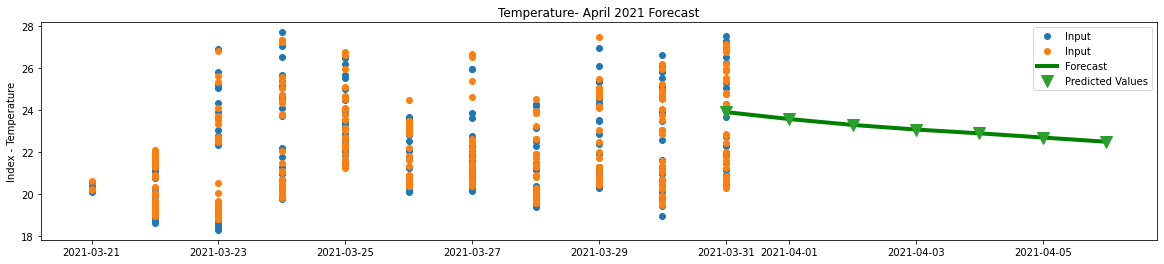

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.86


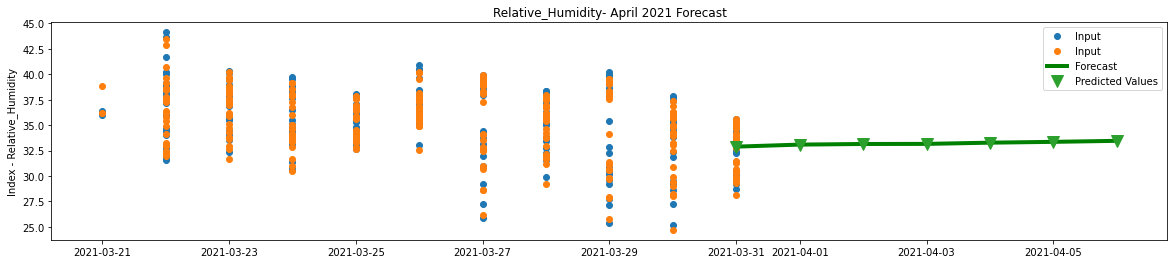

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.25


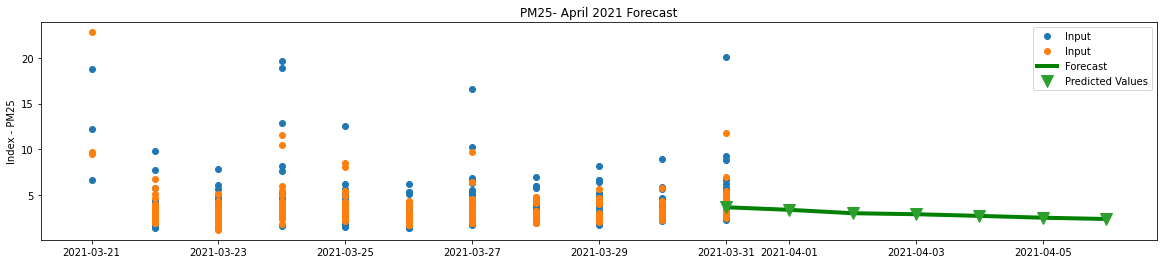

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.6


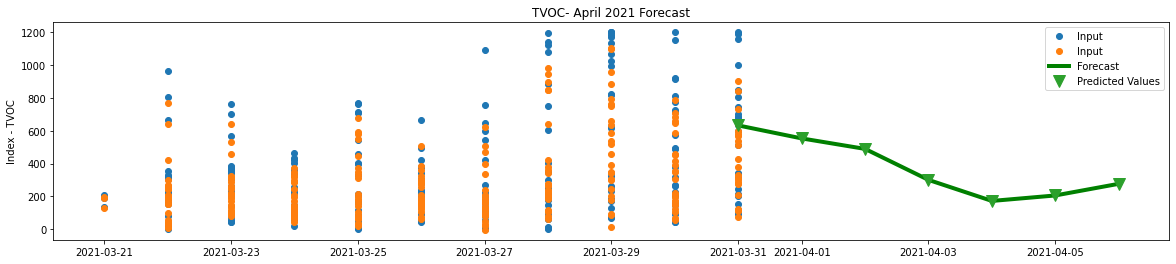

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.51


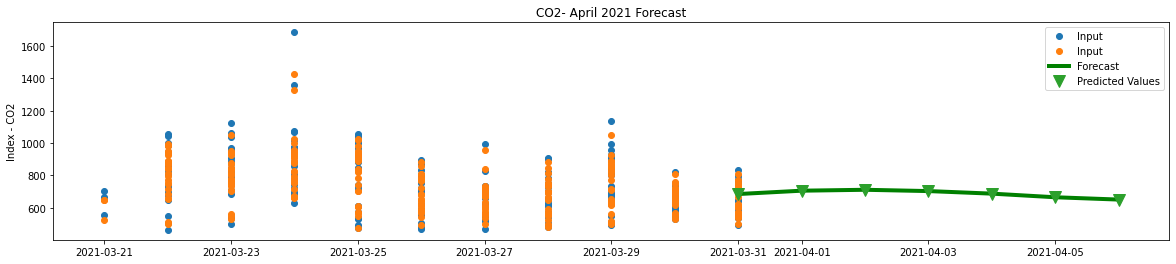

CO total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


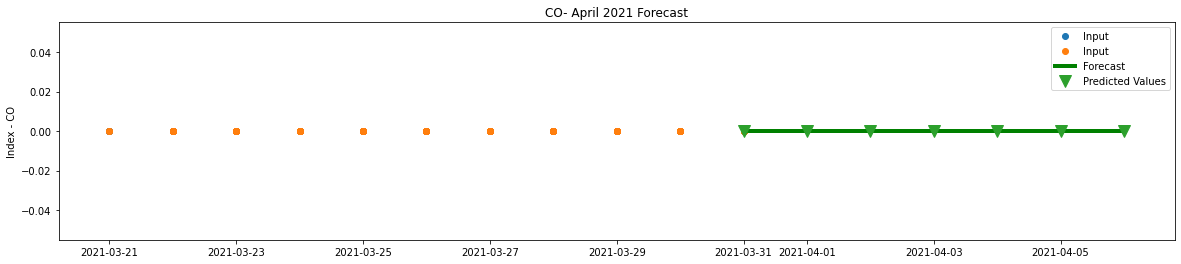

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


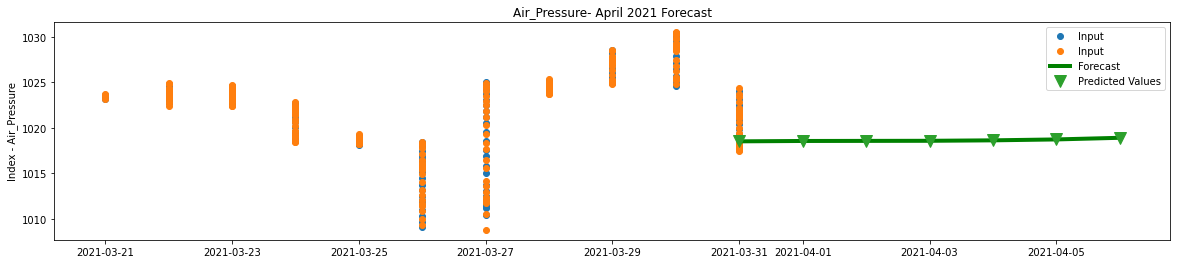

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.68


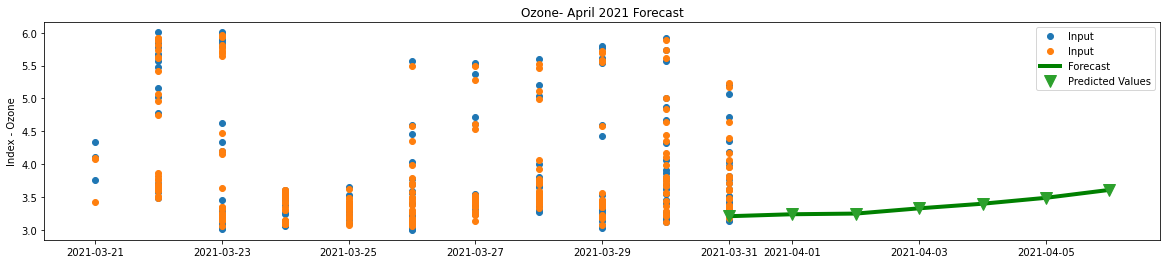

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.01


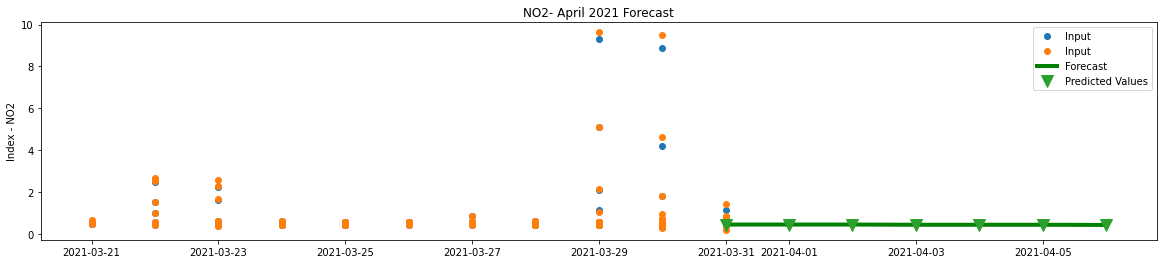

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.38


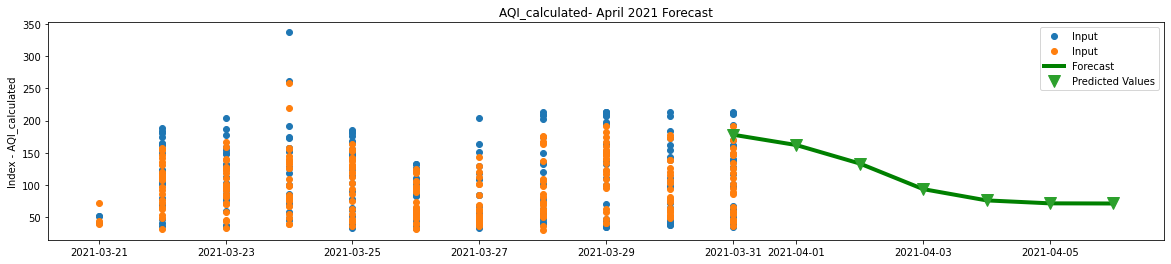

In [99]:
seven_day_forecast_svr = create_dates('2021-03-30',7)
# Creat_Dates function 
for i in range(len(all_air_index.columns)):

    # preprocessing
    station_value, index_name = get_value_name(all_air_index,i)       
    train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)       
    # it is where the test set is split into the amount of 80%. 
    train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)  
    # Data_trainsformation.  With the goal to reproduce the data-frame into the new shape, which apply train and test_tract1. 
    train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,30+1)
    test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, 30+1)        
    X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                       test_tract1)

    # SVR modeling
    model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                            X_test_tract1_array, y_test_tract1_array)                       
    test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, 30)        
    seven_7_svr = forecast_svr(X_test_tract1_array, 7, model_svr, 30, scaler)            
    seven_day_forecast_svr[index_name] = np.array(seven_7_svr)           

    # Plot of scatter plot. 
    plt.figure(figsize=(20,4))
    plt.plot(test_tract1_pred, 'o', label='Input')
    plt.plot(seven_day_forecast_svr[index_name], color='green', label='Forecast', linewidth=4, markersize=12) 
    plt.plot(seven_day_forecast_svr[index_name],'v', markersize=12, label='Predicted Values')
    plt.ylabel('Index - ' + index_name)
    plt.legend(loc='upper right')
    plt.title(index_name + '- April 2021 Forecast')
    plt.xticks(fontsize = 10) 
    plt.show() 

Temperature total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.95


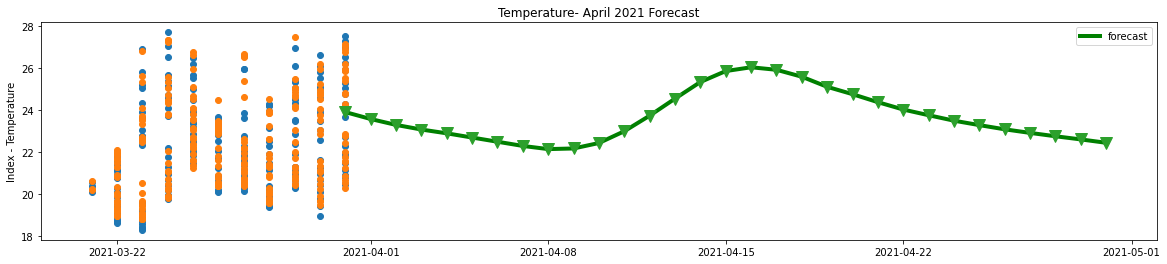

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.86


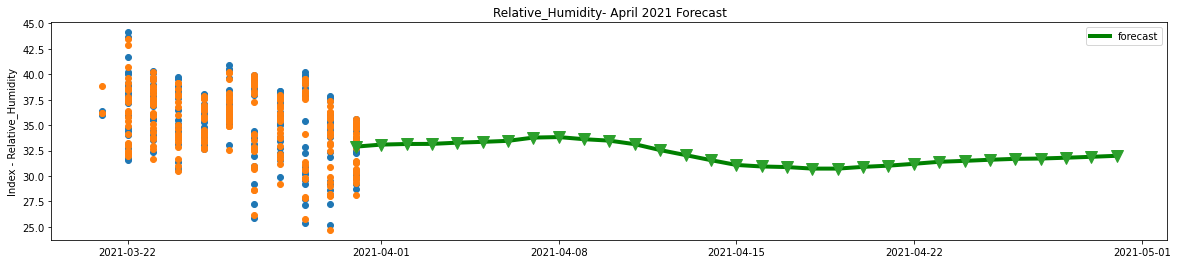

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.25


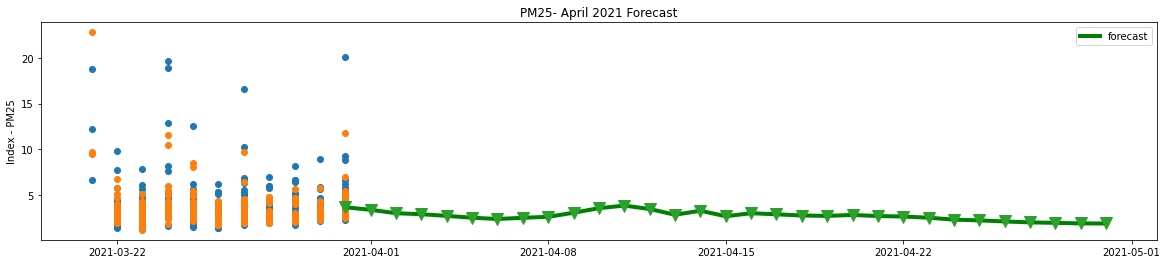

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.6


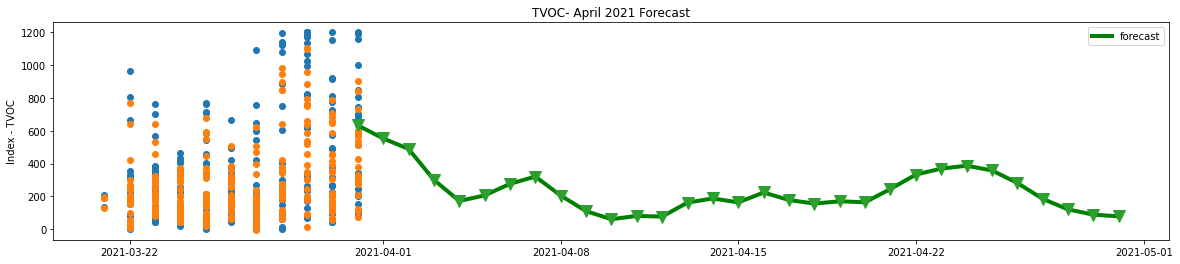

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.51


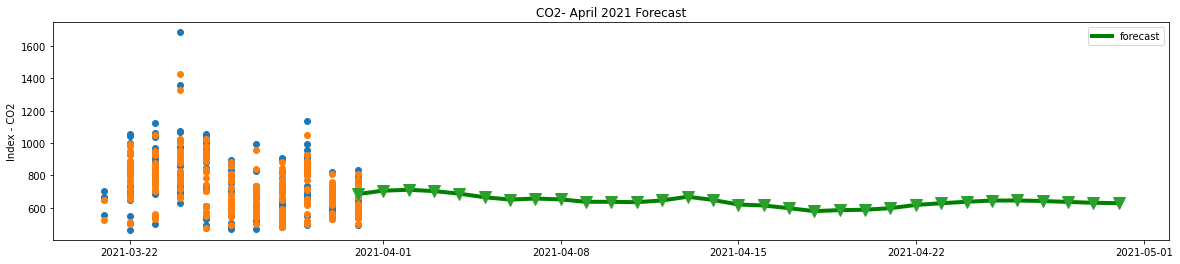

CO total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


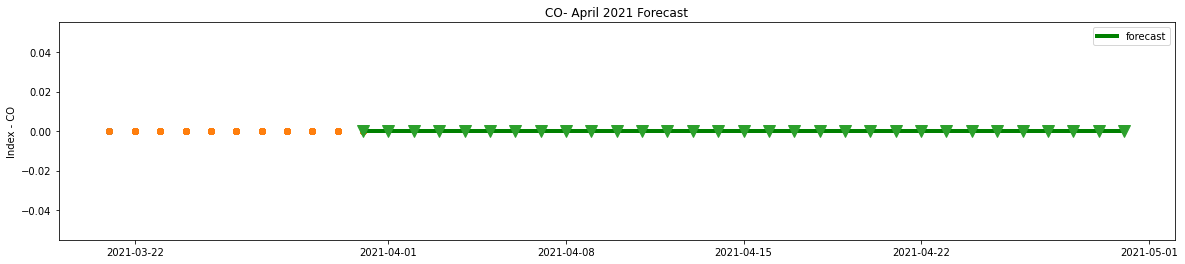

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


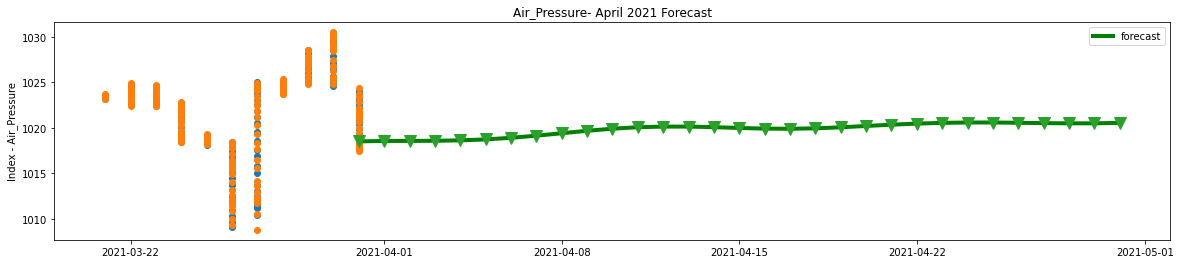

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.68


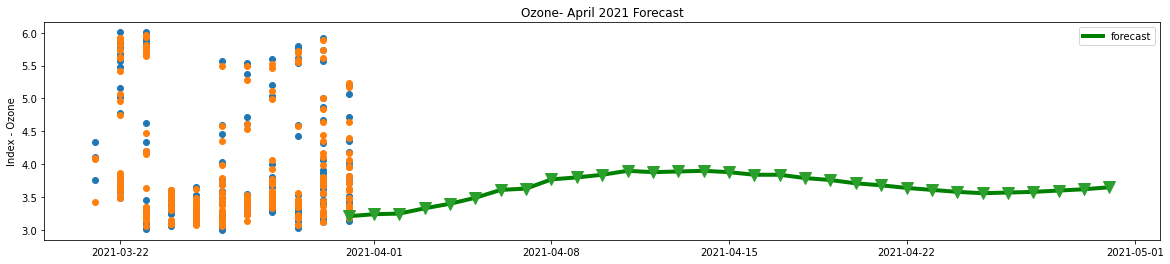

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.01


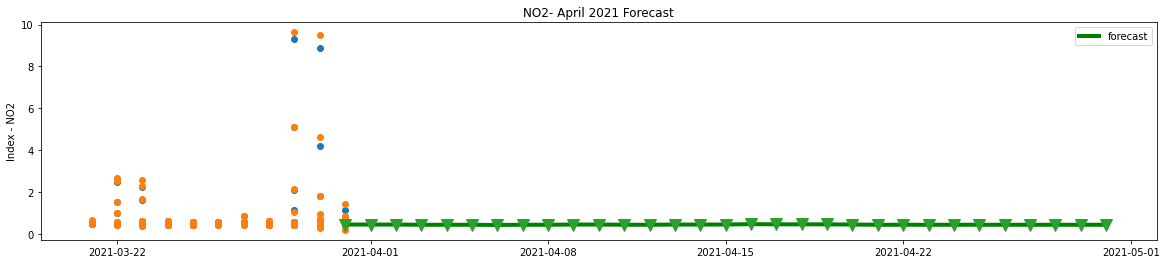

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.38


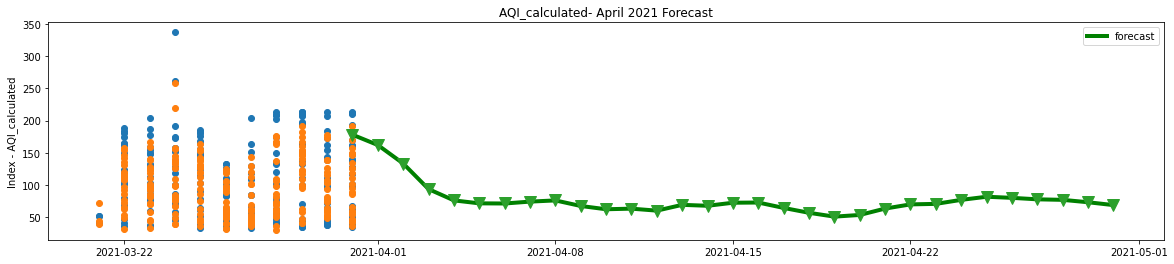

In [22]:
svr_prediction = predict_function(all_air_index, 30, 31)

In [23]:
# Change station names to index
forcast_data_svm = svr_prediction.transpose()
# Make station names to a column
forcast_data_svm_station = forcast_data_svm.reset_index()
forcast_data_svm_station = forcast_data_svm_station.rename(columns={'index':'Station'})
# We tried to pivot the length of output. 

forcast_data_svm_station.head()

,Station,2021-03-31 00:00:00,2021-04-01 00:00:00,2021-04-02 00:00:00,2021-04-03 00:00:00,2021-04-04 00:00:00,2021-04-05 00:00:00,2021-04-06 00:00:00,2021-04-07 00:00:00,2021-04-08 00:00:00,...,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,2021-04-28 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00
0,Temperature,23.90,23.57,23.29,23.07,22.89,22.69,22.49,22.29,22.14,...,24.37,24.02,23.75,23.49,23.28,23.08,22.91,22.75,22.60,22.44
1,Relative_Humidity,32.89,33.09,33.15,33.16,33.28,33.36,33.46,33.78,33.83,...,31.02,31.20,31.40,31.49,31.60,31.69,31.72,31.80,31.89,31.99
2,PM25,3.70,3.42,3.05,2.94,2.76,2.56,2.42,2.55,2.66,...,2.74,2.69,2.56,2.35,2.27,2.15,2.05,2.00,1.94,1.93
3,TVOC,632.29,553.19,489.26,300.39,172.26,205.63,276.58,320.56,205.25,...,245.18,332.89,369.14,386.94,358.19,282.14,185.15,120.68,88.74,78.18
4,CO2,684.64,705.30,710.92,702.90,687.10,664.69,650.37,656.78,651.37,...,597.41,617.12,627.53,636.89,644.14,644.92,641.50,635.93,630.44,628.24


# Export SVM Model to Json. 

In [24]:
# svr_prediction.to_csv('Export_DataFrame.CSV')

# svr_prediction.to_json ('Export_DataFrame.json')

The reason it has exported to Json is to deploy into the web application. 

# Define LSTM model


LSTM: 

LSTM (Long short-term memory) first proposed by Hochreiter & Schmidhuber, is a type of Recurrent Neural Network(RNN). RNN could be defined as a special kind of neural network which can retain information from past inputs which is not possible for traditional neural networks. This makes it suitable for forecasting timeseries data wherein prediction is done based on past data. LSTM is built of units, each consisting of four neural networks, which are used to update its cell state using information from new inputs and past outputs.

A function is created here which encapsulates the steps for processing and predicting from the timeseries data.

First an empty datetime DataFrame is created for the number of days the temperature , other index is to be forecasted, where future predicted values will be stored.

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)







In [25]:
# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    # lr = Learning Rate = 0.001. 
    # Check the complie base on Adam - Giving the loss value in Mean_square_error. 
    
    model.fit(trainX, y_train_tract1_array, batch_size=120, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=0)
    # The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
    # Set the number of epochs is 100.
    # The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
    # Set the batch_size is 120. 
    return model
# We have multiple layer in here. 

Support the layer understanding: 

`Adaptive Gradient Algorithm` (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

`The sequential() ` model API is a way of creating deep learning models where an instance of the Sequential class is created and model layers are created and added to it.




# Validation result 

In the validation method, the fitted model is used here to predict on the test set and the results are added to a column called Forecast for visualization. The accuracy of the predicted result is measured by r-square method, to check its similarity with the actual temperature readings, which is intuitive to interpret.

In [26]:
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    # Predict for TextX , the test set is just use to compare to have the score of R-squared. 
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)  
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
    return test_tract1_pred 

# Multi step future forecast for next days number of days. 

## Hyper Tunning and Forcast

In [27]:
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
# The array to store seven day index. 
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days   

LSTM model with three hidden layer is created each having a user input number of LSTM memory units, with a dropout rate of 20% for each layer, and a final output dense layer predicting a single value.


In [69]:
def index_air_lstm(all_air_index, lag, days):    
    
    seven_day_forecast_lstm = create_dates('2021-3-31',days) 
    # The forecast progression will start from the current choosen day, which force to the future of seven day. 
    for i in range(len(all_air_index.columns)):
        
        # preprocessing data 
        station_value, index_name = get_value_name(all_air_index,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(20, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[index_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred, 'o')     
        # Make the marker with scatter plot. 
        plt.plot(seven_day_forecast_lstm[index_name], color='blue', label='forecast',linewidth=4, markersize=12 ) 
        plt.plot(seven_day_forecast_lstm[index_name],'v', markersize=12)
        # Make the marker with V with it size. 
        plt.ylabel('AirIndex')
        plt.legend(loc='upper right')
        plt.title(index_name + '- April 2021 Air Forecast Quality')
        plt.show()        
        
    return(seven_day_forecast_lstm)

# R-Square explain: 


The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
In general, the higher the R-squared, the better the model fits your data. However, there are important conditions for this guideline that I’ll talk about both in this post and my next post.

Temperature total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.816248


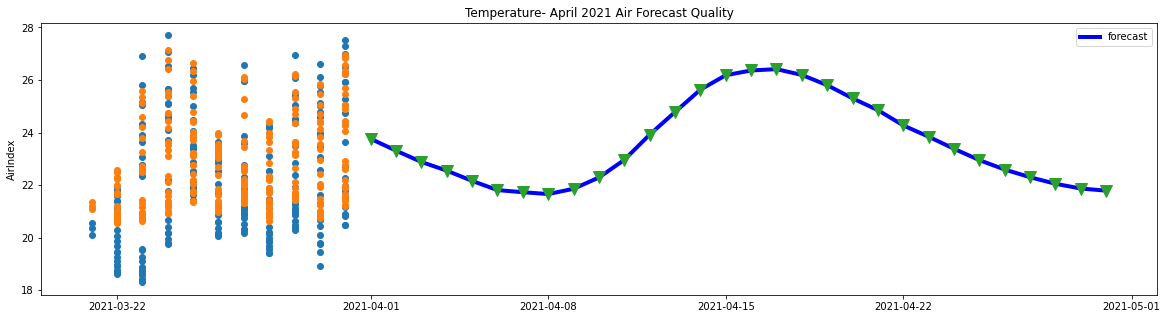

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.716353


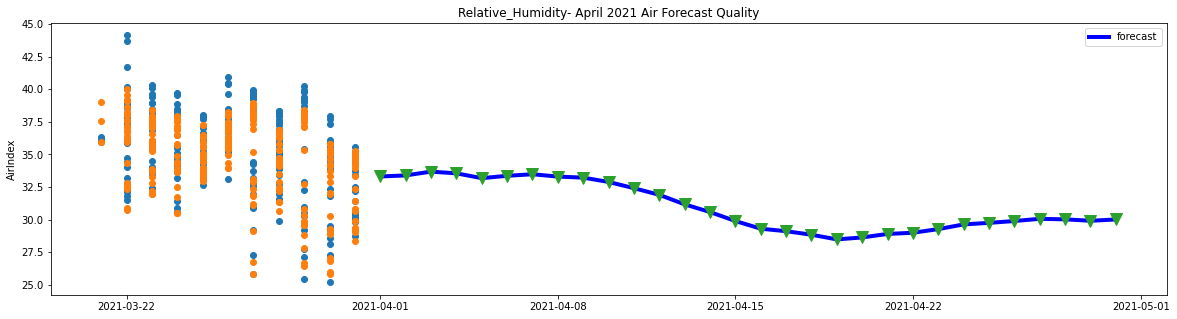

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.191001


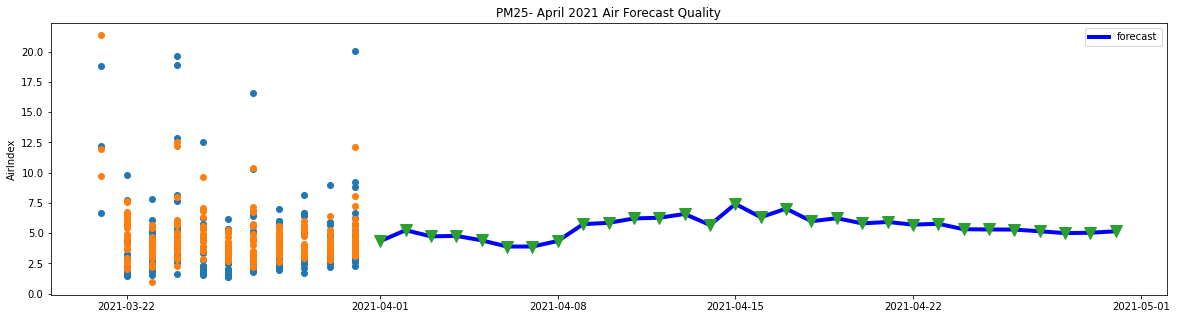

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.550019


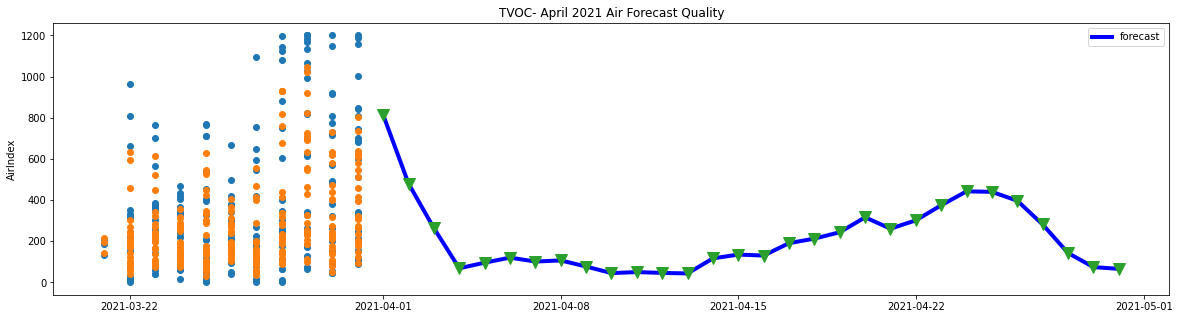

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.515022


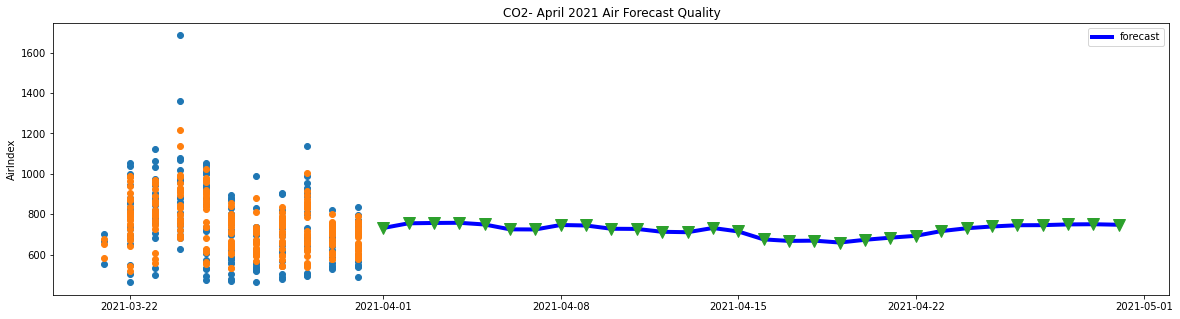

CO total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 1.000000


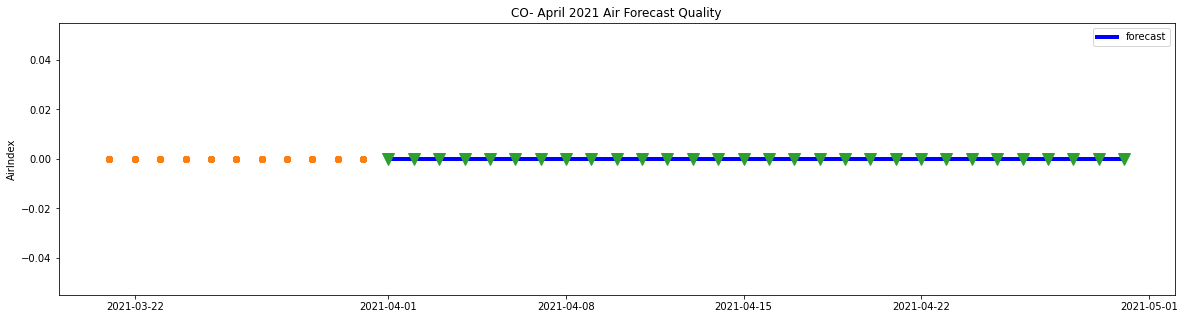

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.959361


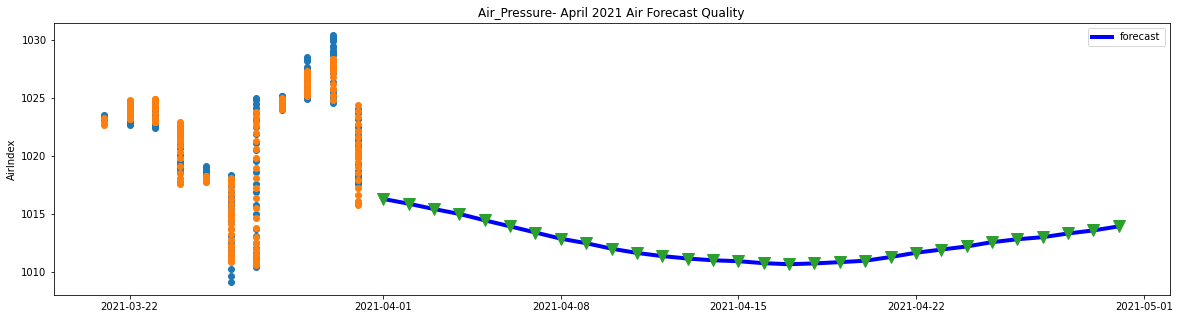

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.660858


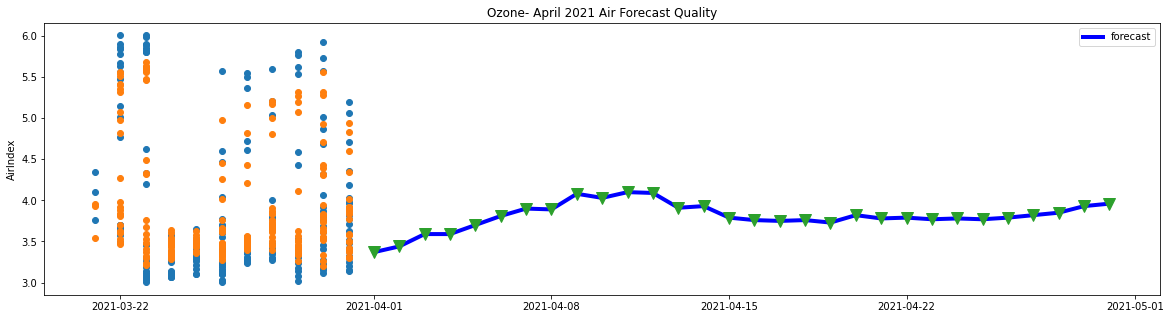

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.041553


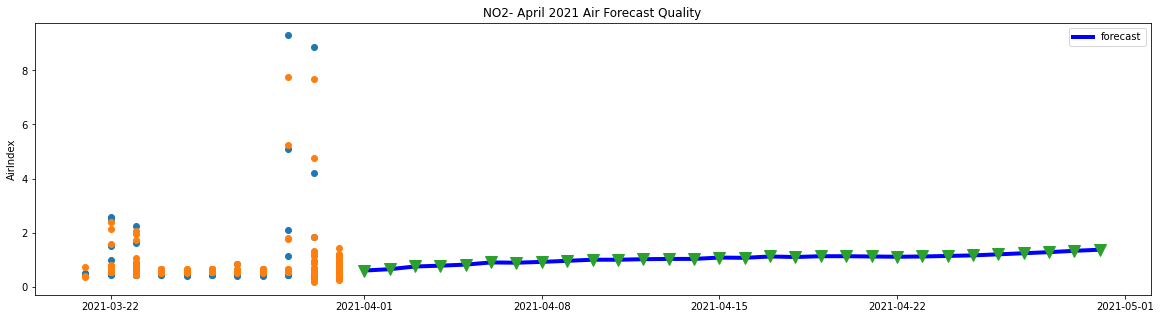

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.406000


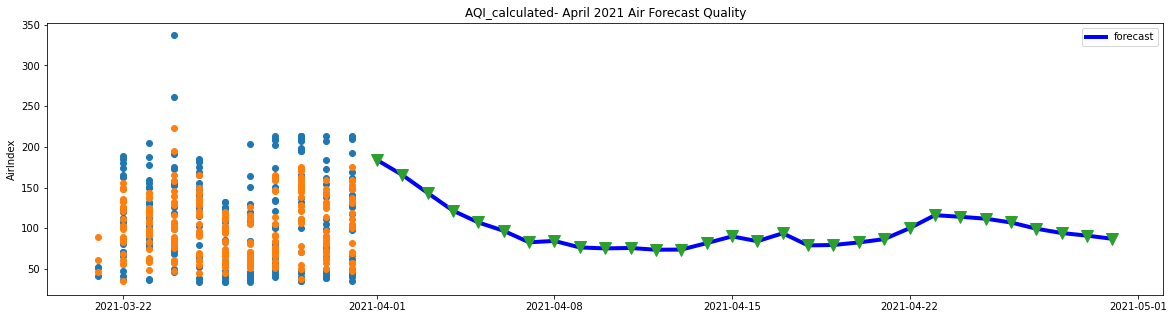

In [70]:
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = index_air_lstm(all_air_index,30,30)
## 7 is the number of day to be forecasting. 

Yellow and Blue Scatter point is identify for the original data. In a single we do have difference amount of Data 
Which spread out normaly into Hour and Minutes.

**Temperature** Show good future prediction in 1 month with 0.81 of R-Squared.

**Relative Humiditiy** show good future predictio of 1 month with 

**TVOC** Show as 0.55 of R-Squared. 

**CO2** Show the result with 0.51 it is normal number. Obviously, this point is not high number

**Air_Pressure** Show good result of prediction data in 1 month with 0.95 as high the trend is going to be smooth down and balance upper way ahead at the end of the month. 

**Ozone** Show the result of R-square is around 0.660858 which quite not so high. As it comtemplate for weather forcast. 100% it won't be high accuracy due to different impact of Data and outside factor might impact into the different index such as rain, fire, or pollution level. 

**AQI_Calculated** we have R-square 0.406 which forcast the future of Air Quality Index is smaller and more fluctuate in the future 30 days. 

The idea is we took only the high R-square feature from each model SVM and LSTM export to CSV, and pickup the high level of each different model in 2 method and merge them together to give the right outcome with maximum level of prediction result. 


# Conclusion: 

In this notebook, Interesting differences were observed while forecasting daily temperatures using the two models. Here the SVR model was able to capture the daily fluctuations in greater detail which looked more real compared to the forecast returned by the LSTM model, as observed from the forecast plots. Besides, the total run time for the SVR model for fitting the data was only a few minutes and was far less than the time taken by the LSTM model, which was training for 100 epochs for each station.

Similarly, a timeseries air-quality-index dataset was used to predict daily of different air index for Sensor in Eco-village for the month of Febuary using historic data from 5-7 different air index. Two methods were used for the study — first a deep learning framework of LSTM was used followed by a machine learning method of Support Vector Regression. Both the models were able to model the data relatively well as evident from the high accuracy obtained for both train and test set. However, the SVM model was consistently performing better than the LSTM model with higher accuracy. Some instances of low accuracy for both the models were caused for certain stations due to less training data points available.



# Explore Data Analyis of Prediction

In [30]:

# svr_prediction.to_csv('Export_DataFrame.CSV')
prediction = pd.read_csv('/home/markn/Desktop/DataSensor/Export_DataFrame.csv')
# Export and import to fix the date


After exporting, to fix the collumn date index without date_name from excel. It import the same file to have the visulization of prediction EDA. 

In [31]:
data_df_heat_map = prediction.pivot_table(
    index='Date').fillna(0)

# Select columns to use, optionally subset or use relative numbers
#data_df_heat_map['total'] = data_df_heat_map[data_df_heat_map.columns[0:24]].sum(axis=1)
data_df_heat_map = data_df_heat_map[data_df_heat_map.columns[0:24]]

# setting on the relatie growth numbers
# data_df_heat_map = data_df_heat_map / data_df_heat_map.shift() 

data_df_heat_map.tail(5).loc[::-1].transpose() 
# Show the tail of the data. 

Date,2021-04-19,2021-04-18,2021-04-17,2021-04-16,2021-04-15
AQI_calculated,80.25,67.21,78.39,75.53,63.01
Air_Pressure,1020.74,1020.95,1021.15,1021.41,1021.70
CO,0.00,0.00,0.00,0.00,0.00
CO2,575.94,573.91,631.31,652.88,655.82
NO2,0.51,0.47,0.45,0.65,0.72
Ozone,3.42,3.34,3.41,3.49,3.48
PM25,2.25,2.21,2.56,2.28,1.54
Relative_Humidity,27.91,27.83,27.87,27.52,27.50
TVOC,7.88,18.68,99.49,186.95,241.43
Temperature,23.84,24.23,24.57,24.77,24.88


The code support the original data transform a pivot_table where the air_index title stay on the left side. And Date convert to collumns for each prediction day. 

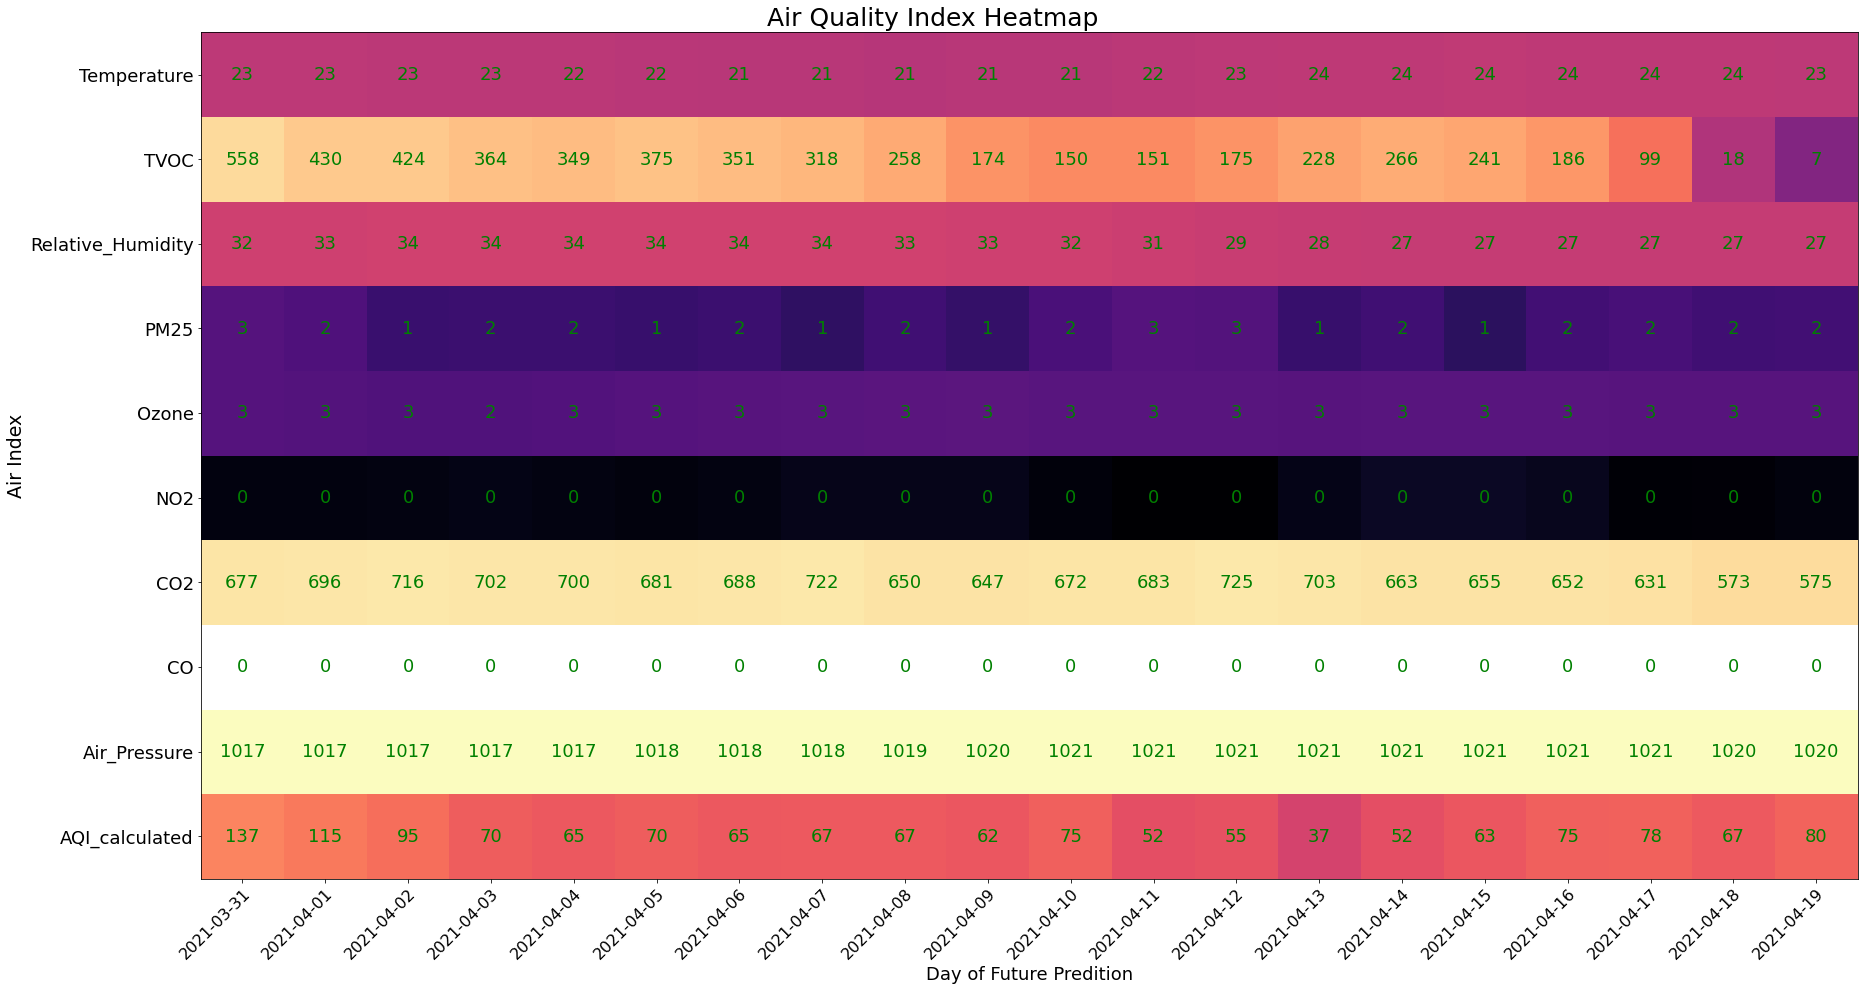

In [34]:
import matplotlib 

## Define array of row and columns headers 
durationsperday = data_df_heat_map.index 
air_index = data_df_heat_map.columns 

## Output size to modified with data size and length 
fig, ax = plt.subplots(figsize=(26,14))

heatmap = plt.imshow(
    np.log(data_df_heat_map[data_df_heat_map > 0].loc[:].transpose()), 
    cmap='magma', 
    interpolation='None', 
    aspect='auto', 
    origin='lower')

# Value add to be axis tick label
ax.set_xticks(np.arange(len(durationsperday)))
ax.set_yticks(np.arange(len(air_index)))
# set the lable for duration per day, and air_index. 
ax.set_xticklabels(durationsperday)
ax.set_yticklabels(air_index)

# X labels diagonally
plt.setp(
    ax.get_xticklabels(), 
    rotation=45, 
    ha="right", 
    rotation_mode="anchor", 
    size=16)

# Y labels diagonally
plt.setp(
    ax.get_yticklabels(), 
    size=18)

# Convert dataframe to numpy dataframe
np_heat = data_df_heat_map.to_numpy() 

# Set numbers as text labeles 
for i in range(len(durationsperday)): 
    for j in range(len(air_index)): 
        text = ax.text(
            i, 
            j, 
            int(np_heat[i, j]), 
            ha="center", 
            va="center", 
            color="g", 
            size=18)
            
# ax.set_title("Positive tests weekly, on sex and age group")
fig.suptitle('Air Quality Index Heatmap', fontsize=25)
plt.xlabel('Day of Future Predition', fontsize=18)
plt.ylabel('Air Index', fontsize=19)
fig.tight_layout() 
plt.show() 

Here it is the graph to show heatmap of the quality where index and ration of temperature & AQI are performance.
It support the customer understand how the plot as easier outlook. With the aim to visulize the AQI compare with different index. 
Clearly show the index and number for each single day performance follow the prediction data. 
* We have NO and CO is alway zero of future prediction due to the originial data. Because the sensor is located inside therefor the number of NO2 and CO is quite stable with Zero. 
* We have the future of Air Quality Index show in the last line where it is quite okay in the 2021-03-21. 
* Temperature quite balance between 23 and 24. 
* CO2 alway stay from the 677 and 700 mg / m3 (milligrams per cubic meter of air). / 
* Relative_Humid are well performance in the future. 